1. Generate Dataset

Generating synthetic banking transaction data...
Synthetic data generated and saved to 'synthetic_banking_transactions.csv'

Sample of the generated data:


,transaction_id,customer_id,account_no,channel,transaction_amount,payee_account_no,transaction_type,currency_code,country_code,location,account_type,transaction_time,account_status,customer_address,is_anomaly
0,4778,4042,457831,online,701.513508,635864,payment,EUR,GB,city_a,savings,2023-01-04 07:37:00,active,Address 4778,0.0
1,2452,3176,487734,branch,3752.191400,486332,transfer,USD,US,city_a,checking,2023-01-02 16:51:00,active,Address 2452,0.0
2,1180,1258,964793,online,4000.669630,433814,transfer,GBP,US,city_c,checking,2023-01-01 19:39:00,active,Address 1180,0.0
3,8552,2053,423255,atm,2623.147623,670462,payment,EUR,EU,city_b,checking,2023-01-06 22:31:00,active,NaN,0.0
4,8949,1934,484866,online,4838.511993,695373,payment,EUR,US,city_a,checking,2023-01-07 05:08:00,active,NaN,0.0



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      10008 non-null  int64         
 1   customer_id         10008 non-null  int64         
 2   account_no          10008 non-null  int64         
 3   channel             9710 non-null   object        
 4   transaction_amount  10008 non-null  float64       
 5   payee_account_no    10008 non-null  int64         
 6   transaction_type    9705 non-null   object        
 7   currency_code       9721 non-null   object        
 8   country_code        9699 non-null   object        
 9   location            9725 non-null   object        
 10  account_type        9715 non-null   object        
 11  transaction_time    9468 non-null   datetime64[ns]
 12  account_status      9702 non-null   object        
 13  customer_address    9725 non-null 

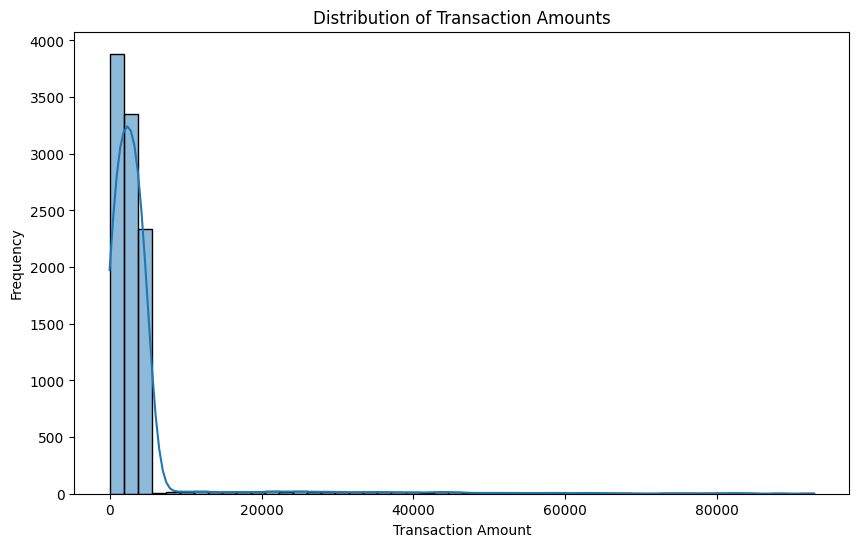

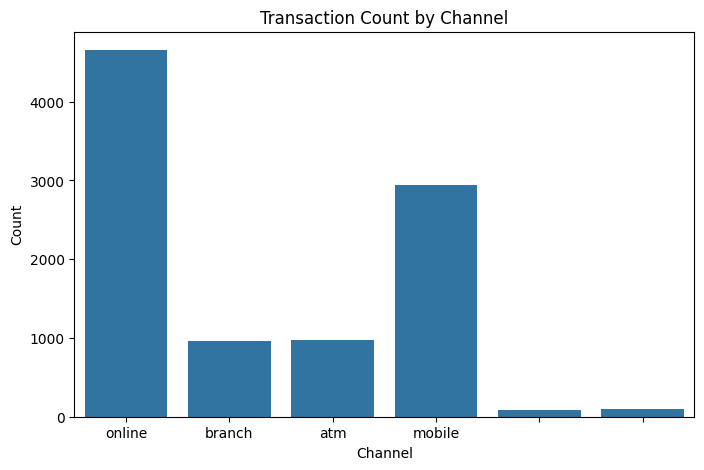

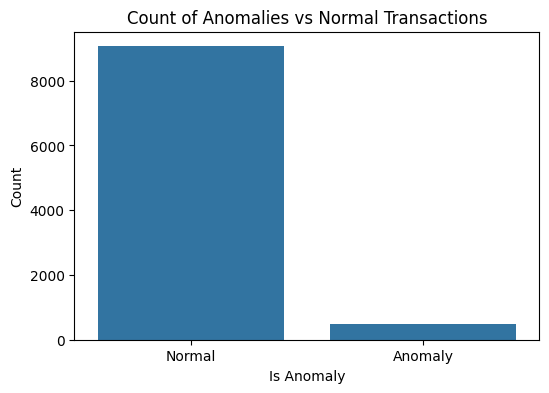

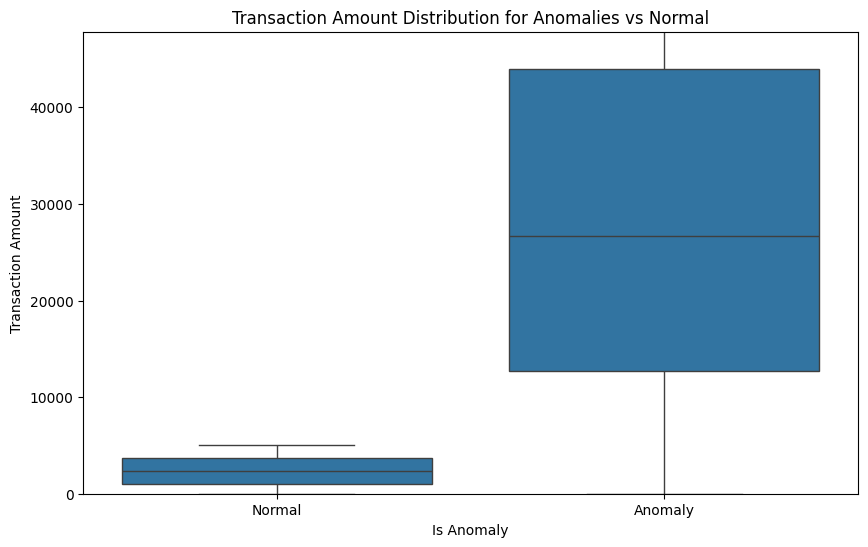

In [2]:
import pandas as pd
import numpy as np

# Function to generate synthetic data
def generate_synthetic_data(num_records=10000, anomaly_ratio=0.05, null_ratio=0.05, repeat_anomaly_customer_ratio=0.05):
    data = {
        'transaction_id': range(1, num_records + 1),
        'customer_id': np.random.randint(1000, 5000, num_records),
        'account_no': np.random.randint(100000, 999999, num_records),
        'channel': np.random.choice(['online', 'mobile', 'branch', 'atm'], num_records, p=[0.5, 0.3, 0.1, 0.1]),
        'transaction_amount': np.random.uniform(10, 5000, num_records),
        'payee_account_no': np.random.randint(100000, 999999, num_records),
        'transaction_type': np.random.choice(['transfer', 'payment', 'withdrawal', 'deposit'], num_records, p=[0.4, 0.3, 0.2, 0.1]),
        'currency_code': np.random.choice(['USD', 'EUR', 'GBP'], num_records, p=[0.7, 0.2, 0.1]),
        'country_code': np.random.choice(['US', 'EU', 'GB'], num_records, p=[0.7, 0.2, 0.1]),
        'location': np.random.choice(['city_a', 'city_b', 'city_c', 'city_d'], num_records, p=[0.4, 0.3, 0.2, 0.1]),
        'account_type': np.random.choice(['checking', 'savings'], num_records, p=[0.7, 0.3]),
        'transaction_time': pd.to_datetime(pd.date_range('2023-01-01', periods=num_records, freq='min')),
        'account_status': np.random.choice(['active', 'inactive'], num_records, p=[0.9, 0.1]),
        'customer_address': ['Address ' + str(i) for i in range(1, num_records + 1)],
        'is_anomaly': 0 # Default to non-anomaly
    }

    df = pd.DataFrame(data)

    # Add anomalies (5% of data)
    num_anomalies = int(num_records * anomaly_ratio)
    anomaly_indices = np.random.choice(df.index, num_anomalies, replace=False)
    df.loc[anomaly_indices, 'is_anomaly'] = 1

    # Introduce anomalies in transaction_amount for anomalous transactions
    df.loc[anomaly_indices, 'transaction_amount'] = df.loc[anomaly_indices, 'transaction_amount'] * np.random.uniform(5, 20, num_anomalies) # Significantly larger amounts

    # Repeat 5% of customers that have anomalies
    anomaly_customer_ids = df.loc[df['is_anomaly'] == 1, 'customer_id'].unique()
    num_repeat_customers = int(len(anomaly_customer_ids) * repeat_anomaly_customer_ratio)
    repeat_customers = np.random.choice(anomaly_customer_ids, num_repeat_customers, replace=False)

    repeat_records = df[df['customer_id'].isin(repeat_customers)].sample(frac=0.1, replace=True) # Sample 10% of their transactions and repeat
    df = pd.concat([df, repeat_records], ignore_index=True)


    # Introduce nulls, empty strings, and missing values (5% of data points overall)
    num_nulls = int(num_records * null_ratio * len(df.columns))
    for _ in range(num_nulls):
        row_idx = np.random.randint(0, len(df))
        col_name = np.random.choice(df.columns)
        # Introduce different types of missingness
        missing_type = np.random.choice(['null', 'empty_string', 'whitespace'], p=[0.6, 0.2, 0.2])
        if missing_type == 'null':
            df.loc[row_idx, col_name] = np.nan
        elif missing_type == 'empty_string':
             if df[col_name].dtype == 'object':
                df.loc[row_idx, col_name] = ''
             else:
                df.loc[row_idx, col_name] = np.nan # Cannot put empty string in numeric column
        else: # whitespace
             if df[col_name].dtype == 'object':
                df.loc[row_idx, col_name] = '   '
             else:
                df.loc[row_idx, col_name] = np.nan # Cannot put whitespace in numeric column


    # Ensure specified columns are integers
    integer_cols = ['transaction_id', 'customer_id', 'account_no', 'payee_account_no']
    for col in integer_cols:
        # Temporarily convert to numeric, coerce errors to NaN, then fill NaN and convert to Int64 (allows NaN)
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    # Ensure amount is numeric
    df['transaction_amount'] = pd.to_numeric(df['transaction_amount'], errors='coerce').fillna(0)

    # Shuffle the dataset
    df = df.sample(frac=1).reset_index(drop=True)

    return df

# Generate the data
print("Generating synthetic banking transaction data...")
synthetic_df = generate_synthetic_data()

# Save the data to a CSV file
synthetic_df.to_csv('synthetic_banking_transactions.csv', index=False)
print("Synthetic data generated and saved to 'synthetic_banking_transactions.csv'")

# Display the first few rows and info
print("\nSample of the generated data:")
display(synthetic_df.head())
print("\nData Info:")
synthetic_df.info()

# Generate basic graphs
import matplotlib.pyplot as plt
import seaborn as sns

print("\nGenerating basic data visualizations...")

# Distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(synthetic_df['transaction_amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

# Count of transactions by channel
plt.figure(figsize=(8, 5))
sns.countplot(data=synthetic_df, x='channel')
plt.title('Transaction Count by Channel')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.show()

# Count of anomalies vs normal transactions
plt.figure(figsize=(6, 4))
sns.countplot(data=synthetic_df, x='is_anomaly')
plt.title('Count of Anomalies vs Normal Transactions')
plt.xlabel('Is Anomaly')
plt.ylabel('Count')
plt.xticks([0, 1], ['Normal', 'Anomaly'])
plt.show()

# Transaction amount distribution for anomalies vs normal
plt.figure(figsize=(10, 6))
sns.boxplot(data=synthetic_df, x='is_anomaly', y='transaction_amount')
plt.title('Transaction Amount Distribution for Anomalies vs Normal')
plt.xlabel('Is Anomaly')
plt.ylabel('Transaction Amount')
plt.xticks([0, 1], ['Normal', 'Anomaly'])
plt.ylim(0, synthetic_df['transaction_amount'].quantile(0.99)) # Limit y-axis for better visualization
plt.show()

## 2. Data Preprocessing

This section focuses on cleaning and preparing the generated synthetic banking transaction data for anomaly detection. This includes handling missing values, converting data types, and addressing inconsistencies.

Original Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      10008 non-null  int64  
 1   customer_id         10008 non-null  int64  
 2   account_no          10008 non-null  int64  
 3   channel             9607 non-null   object 
 4   transaction_amount  10008 non-null  float64
 5   payee_account_no    10008 non-null  int64  
 6   transaction_type    9617 non-null   object 
 7   currency_code       9630 non-null   object 
 8   country_code        9599 non-null   object 
 9   location            9639 non-null   object 
 10  account_type        9615 non-null   object 
 11  transaction_time    9468 non-null   object 
 12  account_status      9603 non-null   object 
 13  customer_address    9630 non-null   object 
 14  is_anomaly          9536 non-null   float64
dtypes: float64(2), int64(4), object(9

,transaction_id,customer_id,account_no,channel,transaction_amount,payee_account_no,transaction_type,currency_code,country_code,location,account_type,transaction_time,account_status,customer_address,is_anomaly
0,4778,4042,457831,online,701.513508,635864,payment,EUR,GB,city_a,savings,2023-01-04 07:37:00,active,Address 4778,0
1,2452,3176,487734,branch,3752.191400,486332,transfer,USD,US,city_a,checking,2023-01-02 16:51:00,active,Address 2452,0
2,1180,1258,964793,online,4000.669630,433814,transfer,GBP,US,city_c,checking,2023-01-01 19:39:00,active,Address 1180,0
3,8552,2053,423255,atm,2623.147623,670462,payment,EUR,EU,city_b,checking,2023-01-06 22:31:00,active,Unknown,0
4,8949,1934,484866,online,4838.511993,695373,payment,EUR,US,city_a,checking,2023-01-07 05:08:00,active,Unknown,0



Preprocessing Statistics and Graphs:

Value Counts for Categorical Features (after handling missing/empty):

'channel':
channel
online     4655
mobile     2936
atm         974
branch      960
Unknown     483
Name: count, dtype: int64

'transaction_type':
transaction_type
transfer      3752
payment       2936
withdrawal    1899
deposit        936
Unknown        485
Name: count, dtype: int64

'currency_code':
currency_code
USD        6764
EUR        1793
GBP         982
Unknown     469
Name: count, dtype: int64

'country_code':
country_code
US         6642
EU         1889
GB          965
Unknown     512
Name: count, dtype: int64

'location':
location
city_a     3872
city_b     2851
city_c     1904
city_d      926
Unknown     455
Name: count, dtype: int64

'account_type':
account_type
checking    6640
savings     2884
Unknown      484
Name: count, dtype: int64

'account_status':
account_status
active      8563
inactive     945
Unknown      500
Name: count, dtype: int64


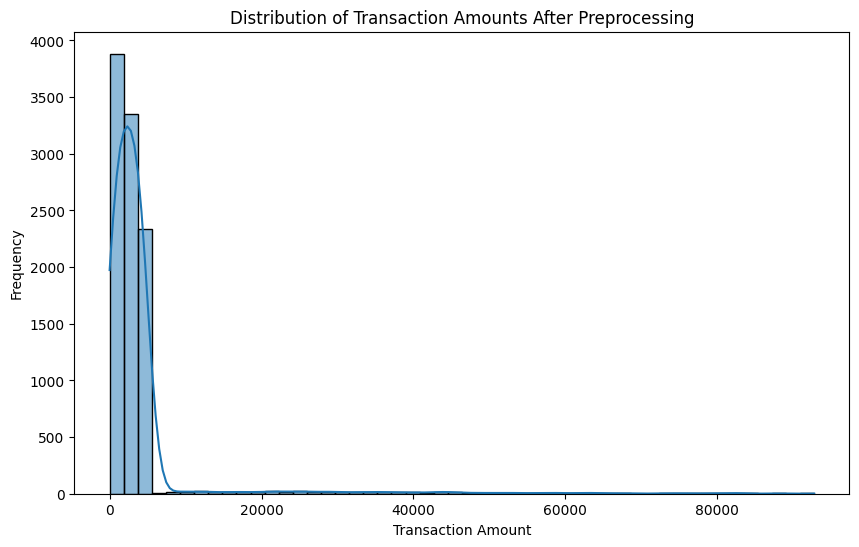

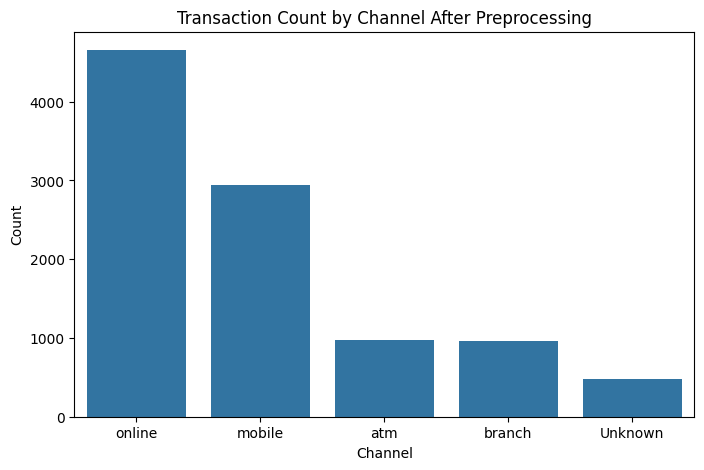

In [5]:
# Reload the dataset to ensure we start fresh with the saved CSV
df = pd.read_csv('synthetic_banking_transactions.csv')

print("Original Data Info:")
df.info()

# --- Handling Missing Values ---
print("\nHandling Missing Values...")

# Calculate percentage of missing values for each column
missing_percentage = df.isnull().sum() / len(df) * 100
print("\nPercentage of Missing Values per Column:")
print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))

# Strategy:
# For numerical columns ('transaction_amount', 'is_anomaly'), fill NaNs with 0
numerical_cols_with_nulls = ['transaction_amount', 'is_anomaly']
for col in numerical_cols_with_nulls:
    if col in df.columns:
        # Address FutureWarning by reassigning instead of using inplace=True
        df[col] = df[col].fillna(0)
        print(f"Filled missing values in '{col}' with 0.")

# For categorical columns, fill NaNs with a placeholder like 'Unknown' or the mode
# Let's use 'Unknown' for clarity
categorical_cols_with_nulls = df.select_dtypes(include='object').columns.tolist() + ['transaction_time'] # Include datetime as object for null check
# Exclude 'customer_address' as it might not be used in modeling
if 'customer_address' in categorical_cols_with_nulls:
    categorical_cols_with_nulls.remove('customer_address')

for col in categorical_cols_with_nulls:
     # Check if the column exists before trying to fillna
    if col in df.columns:
        if df[col].isnull().sum() > 0:
            # For datetime, fill with a placeholder or drop if appropriate, filling with 'Unknown' might not be suitable
            if pd.api.types.is_datetime64_any_dtype(df[col]):
                 # Option 1: Fill with a specific past date (e.g., epoch start) or a placeholder
                 # Address FutureWarning by reassigning
                 df[col] = df[col].fillna('1970-01-01 00:00:00') # Using a string placeholder
                 print(f"Filled missing values in '{col}' with '1970-01-01 00:00:00'.")
            else: # Handle object/string types
                # Address FutureWarning by reassigning
                df[col] = df[col].fillna('Unknown')
                print(f"Filled missing values in '{col}' with 'Unknown'.")


# Verify that there are no more missing values in the handled columns
print("\nMissing values after handling:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# --- Handling Empty Strings and Whitespace in Object Columns ---
print("\nHandling Empty Strings and Whitespace...")
object_cols = df.select_dtypes(include='object').columns

for col in object_cols:
    if col in df.columns:
        # Replace empty strings and strings with only whitespace with NaN first
        # Address FutureWarning by reassigning
        df[col] = df[col].replace('', np.nan)
        df[col] = df[col].replace(r'^\s*$', np.nan, regex=True)

        # Now fill these newly created NaNs, perhaps with 'Unknown' or mode
        if df[col].isnull().sum() > 0:
             # Address FutureWarning by reassigning
             df[col] = df[col].fillna('Unknown')
             print(f"Filled empty/whitespace values in '{col}' with 'Unknown'.")

# Verify again
print("\nMissing values after handling empty strings/whitespace:")
print(df.isnull().sum()[df.isnull().sum() > 0])


# --- Data Type Conversion ---
print("\nConverting Data Types...")

# Convert 'transaction_time' to datetime objects if not already
# The previous fillna might have converted it to object, so reconvert
if 'transaction_time' in df.columns:
    # Coerce errors will turn unparseable dates into NaT (Not a Time)
    df['transaction_time'] = pd.to_datetime(df['transaction_time'], errors='coerce')
    # Fill any NaT values that resulted from coercion (e.g., the '1970-01-01 00:00:00' string placeholder might become NaT)
    # Address FutureWarning by reassigning
    df['transaction_time'] = df['transaction_time'].fillna(pd.to_datetime('1970-01-01 00:00:00')) # Fill with a valid datetime
    print("Converted 'transaction_time' to datetime.")
else:
    print("'transaction_time' column not found.")


# Ensure integer columns are indeed integers (handling potential NaNs introduced and filled)
integer_cols = ['transaction_id', 'customer_id', 'account_no', 'payee_account_no']
for col in integer_cols:
     if col in df.columns:
        # Convert to numeric first, coercing errors, then to Int64 which handles NaNs (although we filled NaNs with 0)
        # Using .astype(int) after filling NaNs with 0 should be safe now.
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
        print(f"Ensured '{col}' is integer type.")
     else:
         print(f"Warning: Integer column '{col}' not found in the dataframe.")


# Ensure 'transaction_amount' is float
if 'transaction_amount' in df.columns:
     df['transaction_amount'] = pd.to_numeric(df['transaction_amount'], errors='coerce').fillna(0.0).astype(float)
     print("Ensured 'transaction_amount' is float type.")
else:
     print("Warning: 'transaction_amount' column not found.")


# Ensure 'is_anomaly' is integer (0 or 1)
if 'is_anomaly' in df.columns:
     df['is_anomaly'] = pd.to_numeric(df['is_anomaly'], errors='coerce').fillna(0).astype(int)
     print("Ensured 'is_anomaly' is integer type (0 or 1).")
else:
     print("Warning: 'is_anomaly' column not found.")


print("\nData Info After Preprocessing:")
df.info()

print("\nSample Data After Preprocessing:")
display(df.head())

# --- Preprocessing Stats and Graphs ---
print("\nPreprocessing Statistics and Graphs:")

# Tabular form of preprocessing stats (e.g., data types, non-null counts)
# df.info() already provides a good summary. Let's also show value counts for key categorical features.
print("\nValue Counts for Categorical Features (after handling missing/empty):")
categorical_cols_for_counts = ['channel', 'transaction_type', 'currency_code', 'country_code', 'location', 'account_type', 'account_status']
for col in categorical_cols_for_counts:
    if col in df.columns:
        print(f"\n'{col}':")
        print(df[col].value_counts(dropna=False)) # dropna=False includes 'Unknown' if present
    else:
        print(f"Warning: Categorical column '{col}' not found.")


# Graphs to show distribution changes or cleaning impact (optional but good)
# Example: Distribution of transaction_amount after filling NaNs (shouldn't change much if fill value is 0)
# Re-plot transaction amount distribution to confirm (should look similar to before)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['transaction_amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts After Preprocessing')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

# Example: Distribution of a categorical feature after filling missing values
# Plot channel distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='channel', order = df['channel'].value_counts().index) # Order by frequency
plt.title('Transaction Count by Channel After Preprocessing')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.show()

# Note: More specific graphs could be added based on the nature of preprocessing steps.
# For instance, if outliers were handled, a boxplot before/after might be useful.

In [4]:
# Save the preprocessed data for the next steps
df.to_csv('synthetic_banking_transactions_preprocessed.csv', index=False)
print("Preprocessed data saved to 'synthetic_banking_transactions_preprocessed.csv'")

Preprocessed data saved to 'synthetic_banking_transactions_preprocessed.csv'


## 3. Feature Engineering

This section focuses on creating new features from the preprocessed banking transaction data. These features are designed to capture various aspects of transaction behavior, location, time, and customer history that could be indicative of anomalous activity.

Original Data Info before Feature Engineering:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      10008 non-null  int64  
 1   customer_id         10008 non-null  int64  
 2   account_no          10008 non-null  int64  
 3   channel             10008 non-null  object 
 4   transaction_amount  10008 non-null  float64
 5   payee_account_no    10008 non-null  int64  
 6   transaction_type    10008 non-null  object 
 7   currency_code       10008 non-null  object 
 8   country_code        10008 non-null  object 
 9   location            10008 non-null  object 
 10  account_type        10008 non-null  object 
 11  transaction_time    10008 non-null  object 
 12  account_status      10008 non-null  object 
 13  customer_address    10008 non-null  object 
 14  is_anomaly          10008 non-null  int64  
dtypes: flo

,transaction_id,customer_id,account_no,channel,transaction_amount,payee_account_no,transaction_type,currency_code,country_code,location,account_type,transaction_time,account_status,customer_address,is_anomaly
0,4778,4042,457831,online,701.513508,635864,payment,EUR,GB,city_a,savings,2023-01-04 07:37:00,active,Address 4778,0
1,2452,3176,487734,branch,3752.191400,486332,transfer,USD,US,city_a,checking,2023-01-02 16:51:00,active,Address 2452,0
2,1180,1258,964793,online,4000.669630,433814,transfer,GBP,US,city_c,checking,2023-01-01 19:39:00,active,Address 1180,0
3,8552,2053,423255,atm,2623.147623,670462,payment,EUR,EU,city_b,checking,2023-01-06 22:31:00,active,Unknown,0
4,8949,1934,484866,online,4838.511993,695373,payment,EUR,US,city_a,checking,2023-01-07 05:08:00,active,Unknown,0



Performing Feature Engineering...

Feature Engineering Complete.

Data Info After Feature Engineering:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   transaction_id               10008 non-null  int64         
 1   customer_id                  10008 non-null  int64         
 2   account_no                   10008 non-null  int64         
 3   channel                      10008 non-null  object        
 4   transaction_amount           10008 non-null  float64       
 5   payee_account_no             10008 non-null  int64         
 6   transaction_type             10008 non-null  object        
 7   currency_code                10008 non-null  object        
 8   country_code                 10008 non-null  object        
 9   location                     10008 non-null  object        
 10  ac

,transaction_id,customer_id,account_no,channel,transaction_amount,payee_account_no,transaction_type,currency_code,country_code,location,...,month,day_of_month,week_of_year,log_transaction_amount,time_since_last_transaction,mean_amount_last_N,std_amount_last_N,count_last_N,is_high_amount,is_unknown_location_channel
0,4926,0,0,online,1574.681178,588998,payment,USD,US,city_c,...,1,1,1,7.362443,0.0,1574.681178,0.000000,1.0,0,0
1,9561,0,736234,online,3953.892840,436416,withdrawal,USD,US,city_a,...,1,1,1,8.282709,0.0,2764.287009,1682.356700,2.0,0,0
2,7161,0,910295,mobile,1264.642831,564459,payment,USD,GB,city_a,...,1,1,1,7.143335,0.0,2264.405616,1471.328058,3.0,0,0
3,9226,0,958955,online,1712.140614,616319,withdrawal,USD,US,Unknown,...,1,1,1,7.446084,0.0,2126.339366,1232.661075,4.0,0,1
4,1973,0,608327,branch,4827.584239,174117,transfer,USD,EU,city_c,...,1,1,1,8.482309,0.0,2666.588340,1612.121201,5.0,0,0



Generating Graphs for Engineered Features...


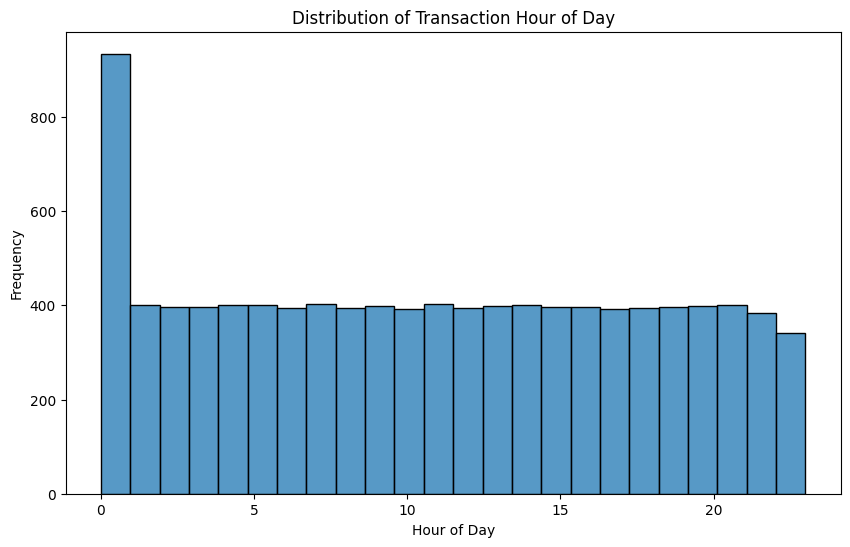

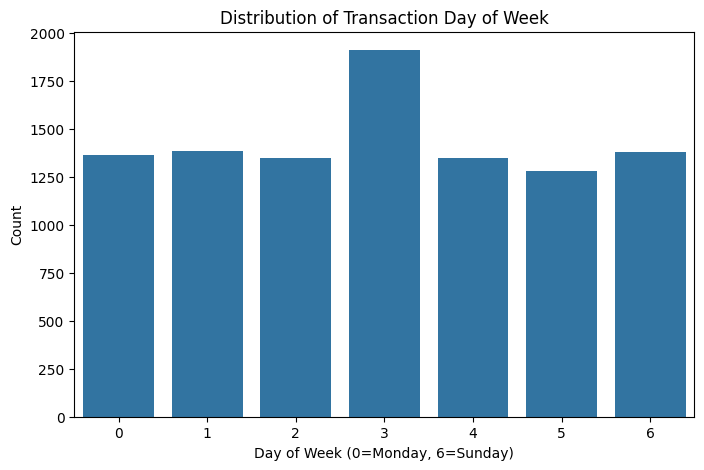

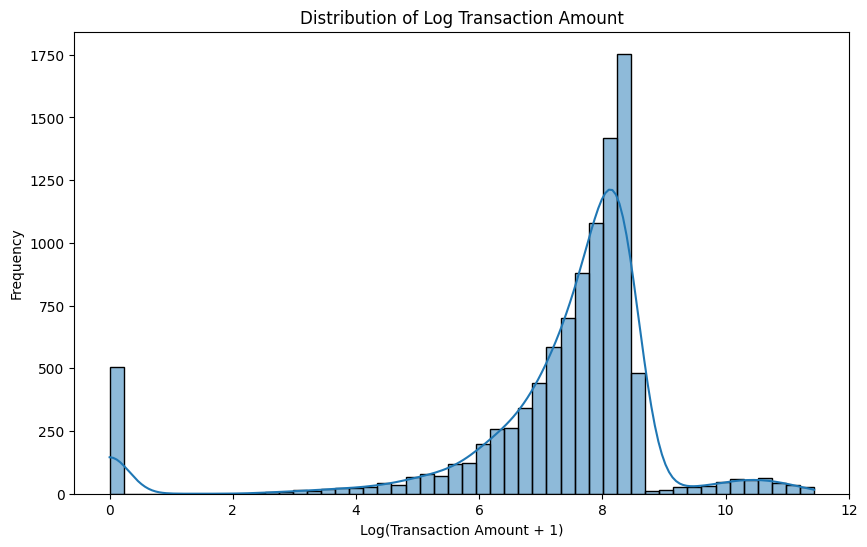

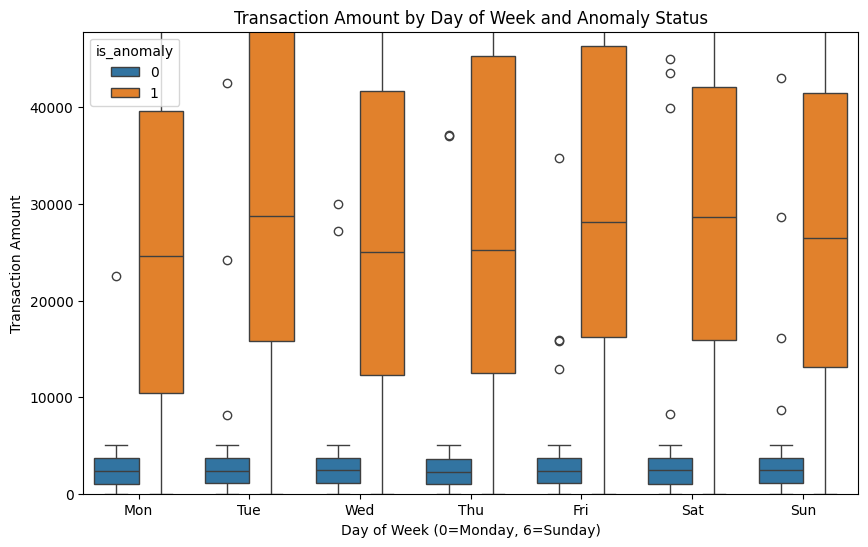

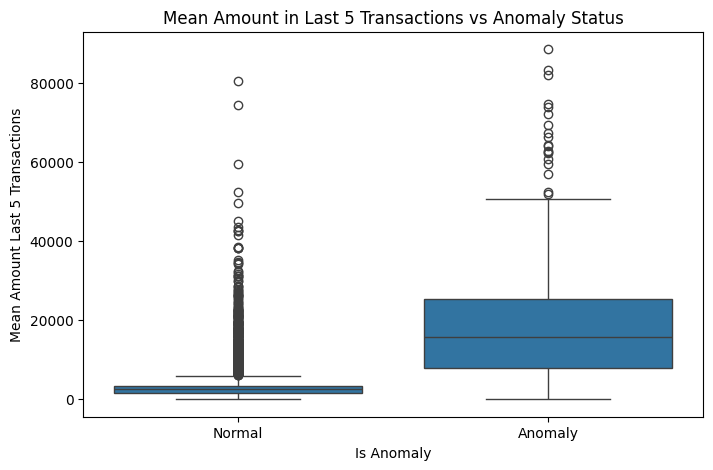

In [6]:
import pandas as pd
import numpy as np

# Load the preprocessed data
df = pd.read_csv('synthetic_banking_transactions_preprocessed.csv')

print("Original Data Info before Feature Engineering:")
df.info()
print("\nSample Data before Feature Engineering:")
display(df.head())

# Ensure 'transaction_time' is datetime objects for time-based features
df['transaction_time'] = pd.to_datetime(df['transaction_time'], errors='coerce')

# Sort data by customer and time for time-series features
df = df.sort_values(by=['customer_id', 'transaction_time']).reset_index(drop=True)

# --- Feature Engineering ---
print("\nPerforming Feature Engineering...")

# 1. Time-Based Features
df['hour_of_day'] = df['transaction_time'].dt.hour
df['day_of_week'] = df['transaction_time'].dt.dayofweek # Monday=0, Sunday=6
df['month'] = df['transaction_time'].dt.month
df['day_of_month'] = df['transaction_time'].dt.day
df['week_of_year'] = df['transaction_time'].dt.isocalendar().week.astype(int)


# 2. Simple Transaction Features (if not already in a useful format)
# 'transaction_amount' is already numeric. Could add log transform if distribution is skewed.
# Let's add log transform for potentially better distribution handling by some models.
df['log_transaction_amount'] = np.log1p(df['transaction_amount']) # log1p handles 0 values

# 3. Customer Behavior Profiles (using time window aggregates)
# Calculate features based on recent transaction history for each customer.
# Requires sorted data.
df['time_since_last_transaction'] = df.groupby('customer_id')['transaction_time'].diff().dt.total_seconds().fillna(0)

# Aggregate features over a rolling time window (e.g., last 24 hours, last 7 days)
# This can be computationally intensive for large datasets.
# Using a fixed window size (e.g., 10 transactions) can be an alternative for speed.
# Let's use a fixed number of previous transactions for simplicity and speed.

window_size = 5 # Look at the last 5 transactions for each customer

# Mean transaction amount over the last N transactions
df['mean_amount_last_N'] = df.groupby('customer_id')['transaction_amount'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

# Standard deviation of transaction amount over the last N transactions
df['std_amount_last_N'] = df.groupby('customer_id')['transaction_amount'].transform(lambda x: x.rolling(window=window_size, min_periods=1).std()).fillna(0) # Fill NaN for first few transactions

# Count of transactions over the last N transactions (effectively window_size if enough history)
df['count_last_N'] = df.groupby('customer_id')['transaction_id'].transform(lambda x: x.rolling(window=window_size, min_periods=1).count())


# 4. Geolocation & Country Features
# These are currently categorical ('location', 'country_code').
# One-hot encoding will handle these for models, but we could create interaction terms or
# frequency-based features if relevant (e.g., number of transactions from a specific location).
# For simplicity, we'll rely on one-hot encoding in the modeling step.

# 5. Device & Channel Features
# 'channel' is categorical. One-hot encoding will handle this.
# Could add features like 'transactions_per_channel_last_N' but this adds complexity.
# Stick to one-hot encoding for now.

# 6. Risk Flags / Rule-based Features
# These would typically come from business rules (e.g., transaction > $1000, transaction in unusual country).
# We can create a few simple rule-based features based on domain knowledge or initial data exploration.

df['is_high_amount'] = (df['transaction_amount'] > 5000).astype(int) # Flag for very high amounts (beyond synthetic normal range)
# Note: The synthetic data already makes anomalies have high amounts, this might overlap with 'is_anomaly' label.
# This feature is more about flagging based on a static threshold.

# Example: Flag if the transaction is from an 'Unknown' location or channel (due to missing data handling)
df['is_unknown_location_channel'] = ((df['location'] == 'Unknown') | (df['channel'] == 'Unknown')).astype(int)


print("\nFeature Engineering Complete.")
print("\nData Info After Feature Engineering:")
df.info()

print("\nSample Data After Feature Engineering:")
display(df.head())

# --- Graphs for Feature Engineering ---
print("\nGenerating Graphs for Engineered Features...")

# Distribution of engineered features
plt.figure(figsize=(10, 6))
sns.histplot(df['hour_of_day'], bins=24, kde=False)
plt.title('Distribution of Transaction Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='day_of_week')
plt.title('Distribution of Transaction Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['log_transaction_amount'], bins=50, kde=True)
plt.title('Distribution of Log Transaction Amount')
plt.xlabel('Log(Transaction Amount + 1)')
plt.ylabel('Frequency')
plt.show()


# Relationship between engineered features and the anomaly label (if available)
# Plot mean transaction amount by day of week, separated by anomaly status
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='day_of_week', y='transaction_amount', hue='is_anomaly')
plt.title('Transaction Amount by Day of Week and Anomaly Status')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Transaction Amount')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylim(0, df['transaction_amount'].quantile(0.99)) # Limit y-axis
plt.show()

# Plot mean amount in last N transactions vs anomaly status
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='is_anomaly', y='mean_amount_last_N')
plt.title('Mean Amount in Last 5 Transactions vs Anomaly Status')
plt.xlabel('Is Anomaly')
plt.ylabel('Mean Amount Last 5 Transactions')
plt.xticks([0, 1], ['Normal', 'Anomaly'])
plt.show()

# Note: More plots can be added to visualize other engineered features and their relationship with 'is_anomaly'.

In [7]:
# Save the data with engineered features for the next steps
df.to_csv('synthetic_banking_transactions_engineered.csv', index=False)
print("Data with engineered features saved to 'synthetic_banking_transactions_engineered.csv'")

Data with engineered features saved to 'synthetic_banking_transactions_engineered.csv'


## 4. Anomaly Detection using LSTM Autoencoder and Isolation Forest

This section focuses on applying two different anomaly detection techniques: an LSTM Autoencoder and Isolation Forest. We will train these models on the prepared data and use them to identify anomalous transactions. The results will be visualized to show the distinction between normal and anomalous data points.

Data Info before Modeling:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   transaction_id               10008 non-null  int64  
 1   customer_id                  10008 non-null  int64  
 2   account_no                   10008 non-null  int64  
 3   channel                      10008 non-null  object 
 4   transaction_amount           10008 non-null  float64
 5   payee_account_no             10008 non-null  int64  
 6   transaction_type             10008 non-null  object 
 7   currency_code                10008 non-null  object 
 8   country_code                 10008 non-null  object 
 9   location                     10008 non-null  object 
 10  account_type                 10008 non-null  object 
 11  transaction_time             10008 non-null  object 
 12  account_status               10008 non-null  ob

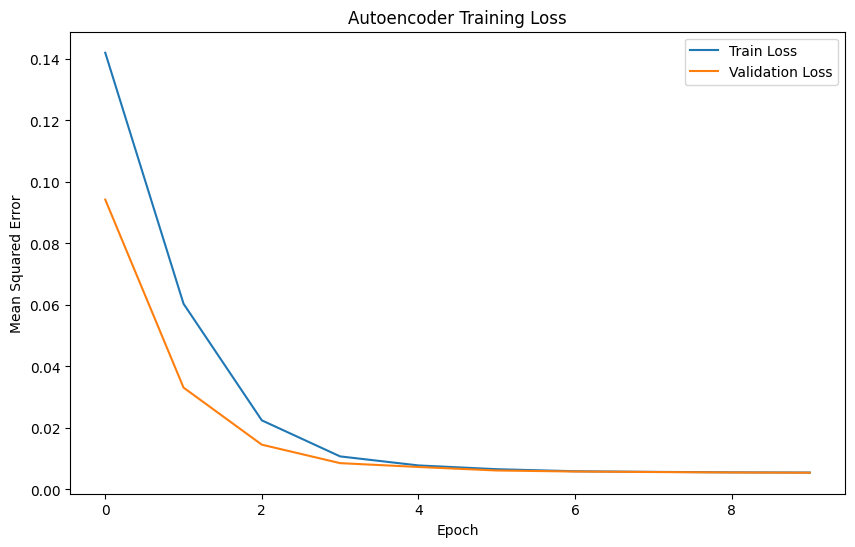

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Autoencoder identified 501 anomalies.


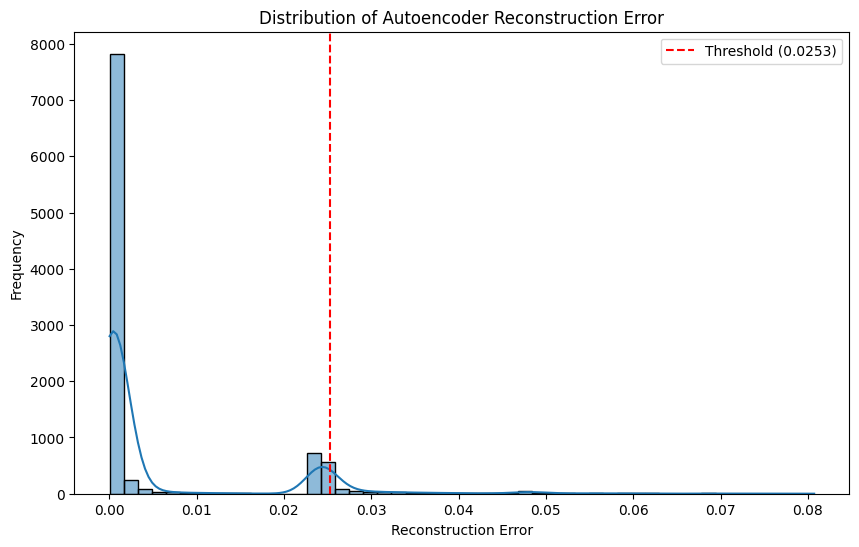

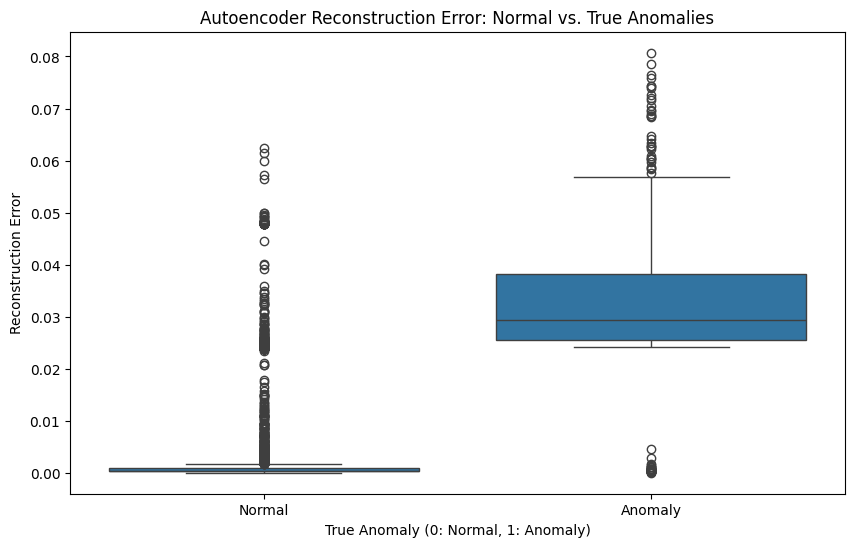


Training Isolation Forest for Anomaly Detection...
Fitting Isolation Forest...
Isolation Forest training complete.

Isolation Forest identified 501 anomalies.


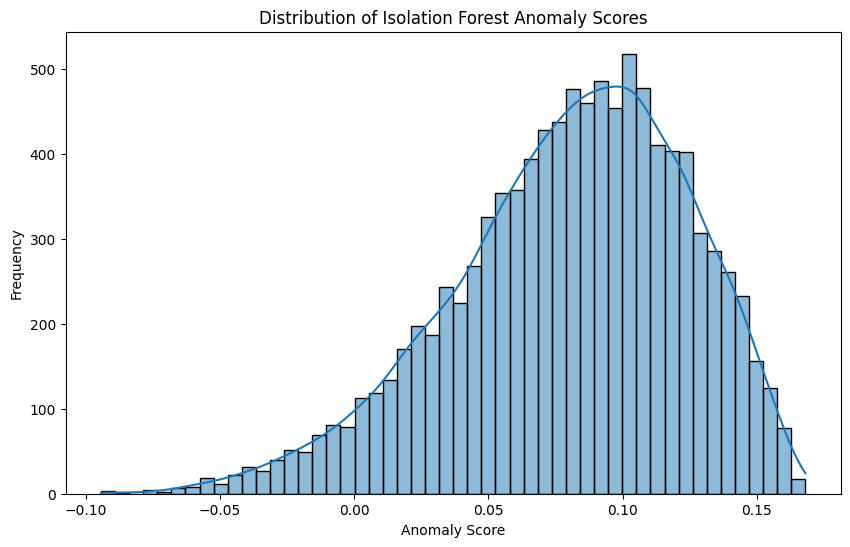

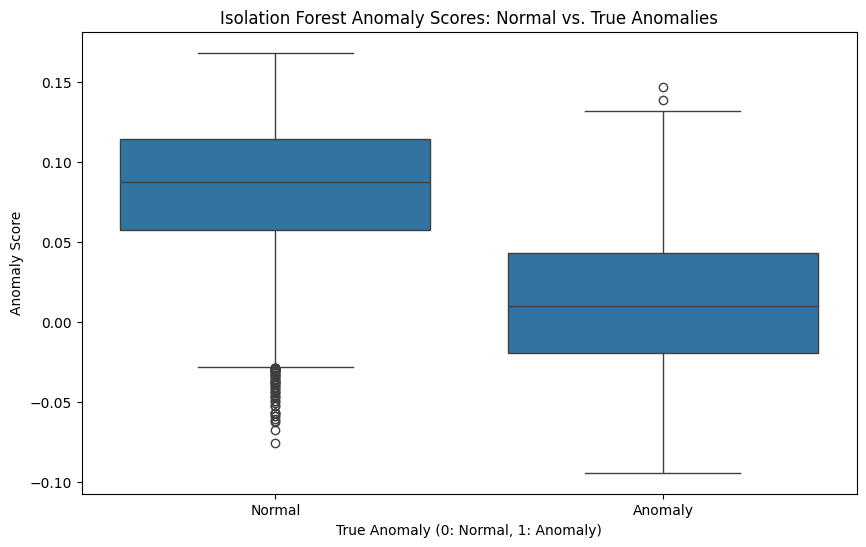


Comparing anomalies detected by Autoencoder and Isolation Forest:
Autoencoder detected 501 anomalies.
Isolation Forest detected 501 anomalies.
Anomalies detected by BOTH models: 224
True anomalies caught by Autoencoder: 362 out of 476
True anomalies caught by Isolation Forest: 190 out of 476


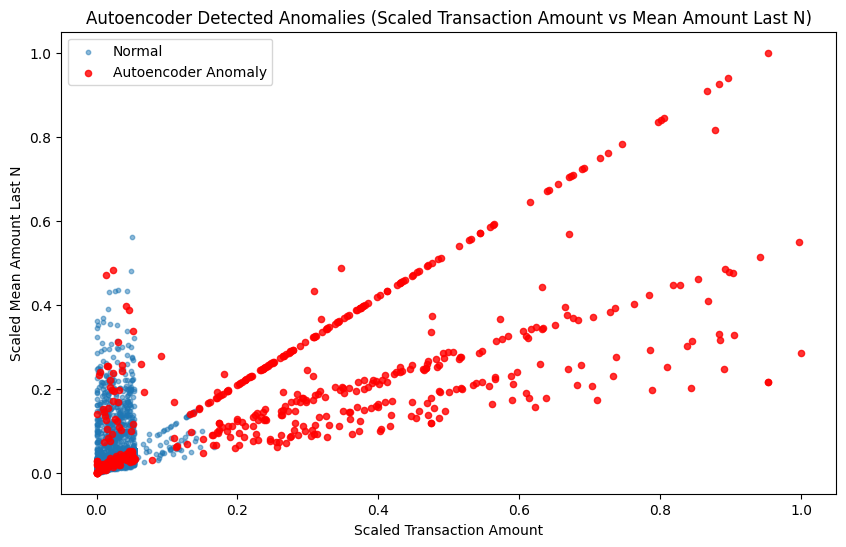

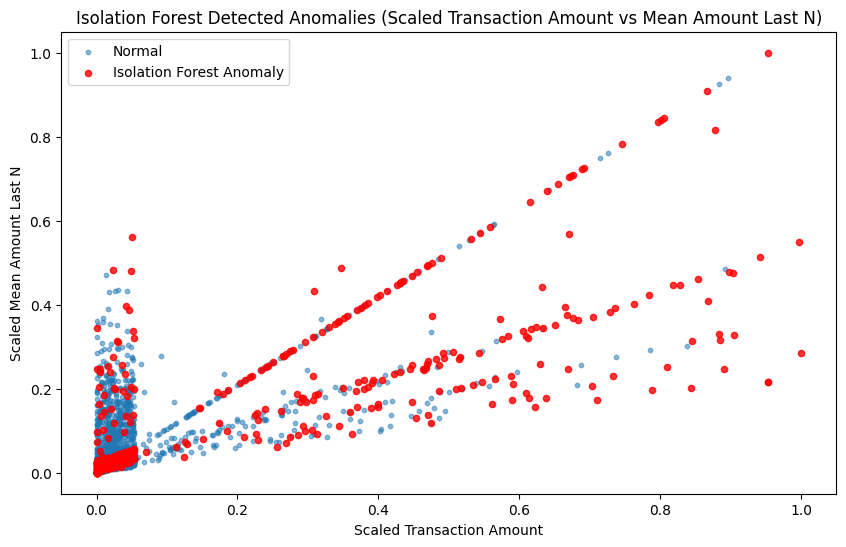

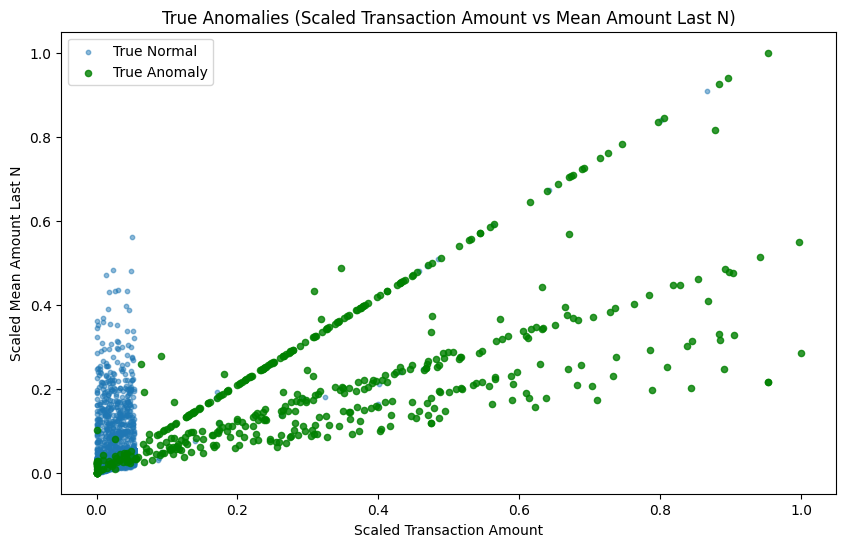

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense
import matplotlib.pyplot as plt
import seaborn as sns

# Load the engineered data
df = pd.read_csv('synthetic_banking_transactions_engineered.csv')

print("Data Info before Modeling:")
df.info()

# Separate features (X) and the true anomaly label (y)
# We'll use 'is_anomaly' as the ground truth for evaluation, but the models will be trained
# in an unsupervised or semi-supervised manner (Isolation Forest is unsupervised,
# Autoencoder is trained to reconstruct normal data).
X = df.drop(['transaction_id', 'customer_id', 'account_no', 'payee_account_no',
             'transaction_time', 'customer_address', 'is_anomaly'], axis=1)
y_true = df['is_anomaly'] # Keep the true labels for evaluation

# Identify categorical and numerical features for preprocessing
categorical_features = X.select_dtypes(include='object').columns
numerical_features = X.select_dtypes(include=np.number).columns

# Create a preprocessing pipeline for scaling numerical features and one-hot encoding categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (shouldn't be any left after selection)
)

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Convert sparse matrix from OneHotEncoder to dense numpy array if necessary for models
if hasattr(X_processed, 'toarray'):
    X_processed = X_processed.toarray()

print(f"\nProcessed data shape: {X_processed.shape}")

# --- Anomaly Detection using LSTM Autoencoder ---
print("\nTraining LSTM Autoencoder for Anomaly Detection...")

# Reshape data for LSTM input: (samples, timesteps, features)
# For this dataset, each transaction is a single timestep.
timesteps = 1
input_dim = X_processed.shape[1] # Number of features after preprocessing
X_lstm = np.reshape(X_processed, (X_processed.shape[0], timesteps, input_dim))

# Define the autoencoder architecture
lstm_inputs = Input(shape=(timesteps, input_dim))
# Encoder
encoded = LSTM(64, activation='relu')(lstm_inputs) # Reduced units for potentially faster training
# Repeat vector for decoding
repeated_encoded = RepeatVector(timesteps)(encoded)
# Decoder
decoded = LSTM(64, activation='relu', return_sequences=True)(repeated_encoded) # Added another layer
decoded_output = Dense(input_dim, activation='sigmoid')(decoded) # Output layer to reconstruct input

# Create the autoencoder model
autoencoder = Model(lstm_inputs, decoded_output)
# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
# Train on the entire dataset (unsupervised).
# A common approach is to train on only "normal" data if true labels are available,
# but here we train on the whole dataset to learn the general data distribution.
print("Fitting Autoencoder...")
# Use a smaller number of epochs for demonstration
history = autoencoder.fit(X_lstm, X_lstm, epochs=10, batch_size=64, validation_split=0.1, verbose=0)
print("Autoencoder training complete.")

# Plot training history (optional but good practice)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


# Calculate Reconstruction Error
X_pred = autoencoder.predict(X_lstm)
# Calculate the mean squared error between the original input and the reconstruction
recon_error = np.mean(np.power(X_lstm - X_pred, 2), axis=(1,2))

# Determine anomaly threshold (e.g., 95th percentile)
threshold_autoencoder = np.percentile(recon_error, 95)
anomalies_autoencoder = recon_error > threshold_autoencoder

print(f"\nAutoencoder identified {sum(anomalies_autoencoder)} anomalies.")

# Plot Reconstruction Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(recon_error, bins=50, kde=True)
plt.axvline(threshold_autoencoder, color='r', linestyle='--', label=f'Threshold ({threshold_autoencoder:.4f})')
plt.title('Distribution of Autoencoder Reconstruction Error')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot Reconstruction Error for Anomalies vs Normal (based on true labels)
# Use the true labels (y_true) to color the reconstruction errors
plt.figure(figsize=(10, 6))
sns.boxplot(x=y_true, y=recon_error)
plt.title('Autoencoder Reconstruction Error: Normal vs. True Anomalies')
plt.xlabel('True Anomaly (0: Normal, 1: Anomaly)')
plt.ylabel('Reconstruction Error')
plt.xticks([0, 1], ['Normal', 'Anomaly'])
plt.show()


# --- Anomaly Detection using Isolation Forest ---
print("\nTraining Isolation Forest for Anomaly Detection...")

# Isolation Forest works directly on the processed 2D data
# 'contamination' is the expected proportion of anomalies in the data.
# We'll use the known anomaly ratio from synthetic data generation (0.05)
# In a real scenario, this would be estimated or tuned.
isolation_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Train the Isolation Forest model
print("Fitting Isolation Forest...")
isolation_forest.fit(X_processed)
print("Isolation Forest training complete.")

# Predict anomaly scores (lower score indicates more anomalous)
anomaly_scores_if = isolation_forest.decision_function(X_processed)

# Predict anomalies (-1 for outliers, 1 for inliers)
# Convert to boolean: True for anomaly (-1), False for normal (1)
anomalies_if = isolation_forest.predict(X_processed) == -1

print(f"\nIsolation Forest identified {sum(anomalies_if)} anomalies.")


# Plot Anomaly Score Distribution (Isolation Forest)
plt.figure(figsize=(10, 6))
sns.histplot(anomaly_scores_if, bins=50, kde=True)
plt.title('Distribution of Isolation Forest Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

# Plot Anomaly Scores for Anomalies vs Normal (based on true labels)
plt.figure(figsize=(10, 6))
sns.boxplot(x=y_true, y=anomaly_scores_if)
plt.title('Isolation Forest Anomaly Scores: Normal vs. True Anomalies')
plt.xlabel('True Anomaly (0: Normal, 1: Anomaly)')
plt.ylabel('Anomaly Score')
plt.xticks([0, 1], ['Normal', 'Anomaly'])
plt.show()


# --- Compare Anomalies Detected by Both Models ---
print("\nComparing anomalies detected by Autoencoder and Isolation Forest:")
print(f"Autoencoder detected {sum(anomalies_autoencoder)} anomalies.")
print(f"Isolation Forest detected {sum(anomalies_if)} anomalies.")

# How many anomalies were detected by *both* models?
both_detected = np.logical_and(anomalies_autoencoder, anomalies_if)
print(f"Anomalies detected by BOTH models: {sum(both_detected)}")

# How many true anomalies were detected by each model?
true_anomalies_indices = y_true == 1
autoencoder_caught_true = np.sum(anomalies_autoencoder[true_anomalies_indices])
if_caught_true = np.sum(anomalies_if[true_anomalies_indices])

print(f"True anomalies caught by Autoencoder: {autoencoder_caught_true} out of {sum(y_true)}")
print(f"True anomalies caught by Isolation Forest: {if_caught_true} out of {sum(y_true)}")

# --- Visualize Detected Anomalies on a Subset of Features ---
# It's hard to visualize in high-dimensional space. Let's pick two important features
# (e.g., transaction_amount and mean_amount_last_N) and plot the detected anomalies.
# We need the original scaled values of these features.

# Get the indices of the two features in the processed data
try:
    amount_idx = numerical_features.get_loc('transaction_amount')
    mean_amount_idx = numerical_features.get_loc('mean_amount_last_N')

    # Get the scaled values for these features
    # Need to redo scaling just for these two features to get their columns in the processed data
    # A better way is to get the column indices from the preprocessor's output
    # This requires inspecting the preprocessor's transformer outputs.
    # A simpler way for visualization is to scale these two columns separately.
    scaler_viz = MinMaxScaler()
    amount_scaled_viz = scaler_viz.fit_transform(df[['transaction_amount']])
    mean_amount_scaled_viz = scaler_viz.fit_transform(df[['mean_amount_last_N']])

    # Combine the scaled features for plotting
    features_for_viz = np.hstack((amount_scaled_viz, mean_amount_scaled_viz))

    # Plot detected anomalies by Autoencoder
    plt.figure(figsize=(10, 6))
    plt.scatter(features_for_viz[~anomalies_autoencoder, 0], features_for_viz[~anomalies_autoencoder, 1], label='Normal', alpha=0.5, s=10)
    plt.scatter(features_for_viz[anomalies_autoencoder, 0], features_for_viz[anomalies_autoencoder, 1], label='Autoencoder Anomaly', alpha=0.8, s=20, color='red')
    plt.title('Autoencoder Detected Anomalies (Scaled Transaction Amount vs Mean Amount Last N)')
    plt.xlabel('Scaled Transaction Amount')
    plt.ylabel('Scaled Mean Amount Last N')
    plt.legend()
    plt.show()

    # Plot detected anomalies by Isolation Forest
    plt.figure(figsize=(10, 6))
    plt.scatter(features_for_viz[~anomalies_if, 0], features_for_viz[~anomalies_if, 1], label='Normal', alpha=0.5, s=10)
    plt.scatter(features_for_viz[anomalies_if, 0], features_for_viz[anomalies_if, 1], label='Isolation Forest Anomaly', alpha=0.8, s=20, color='red')
    plt.title('Isolation Forest Detected Anomalies (Scaled Transaction Amount vs Mean Amount Last N)')
    plt.xlabel('Scaled Transaction Amount')
    plt.ylabel('Scaled Mean Amount Last N')
    plt.legend()
    plt.show()

    # Plot true anomalies
    plt.figure(figsize=(10, 6))
    plt.scatter(features_for_viz[y_true == 0, 0], features_for_viz[y_true == 0, 1], label='True Normal', alpha=0.5, s=10)
    plt.scatter(features_for_viz[y_true == 1, 0], features_for_viz[y_true == 1, 1], label='True Anomaly', alpha=0.8, s=20, color='green')
    plt.title('True Anomalies (Scaled Transaction Amount vs Mean Amount Last N)')
    plt.xlabel('Scaled Transaction Amount')
    plt.ylabel('Scaled Mean Amount Last N')
    plt.legend()
    plt.show()


except KeyError as e:
    print(f"\nCould not plot visualization: Feature {e} not found in numerical features.")
except Exception as e:
    print(f"\nAn error occurred during visualization: {e}")

## 5. Explaining Anomalies using SHAP

This section focuses on interpreting the anomalies detected by the models using the SHapley Additive exPlanations (SHAP) algorithm. SHAP values help in understanding the contribution of each feature to the anomaly score for individual transactions, providing insights into the reasons behind the detected anomalies.

Generated 42 feature names.

Explaining Autoencoder Anomalies using SHAP...
Initializing SHAP KernelExplainer for Autoencoder...
Calculating SHAP values for 501 autoencoder anomalies...


  0%|          | 0/10 [00:00<?, ?it/s]


Generating SHAP summary plot for Autoencoder anomalies...


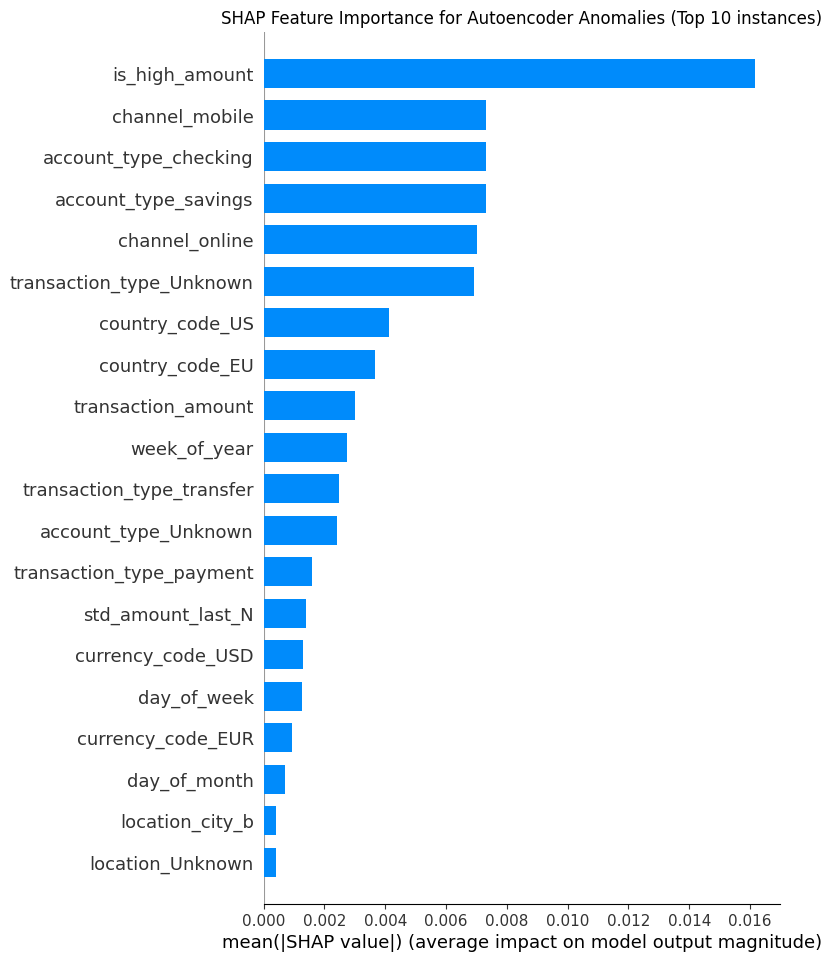


Explaining Isolation Forest Anomalies using SHAP...
Initializing SHAP KernelExplainer for Isolation Forest...
Calculating SHAP values for 501 Isolation Forest anomalies...


  0%|          | 0/10 [00:00<?, ?it/s]


Generating SHAP summary plot for Isolation Forest anomalies...


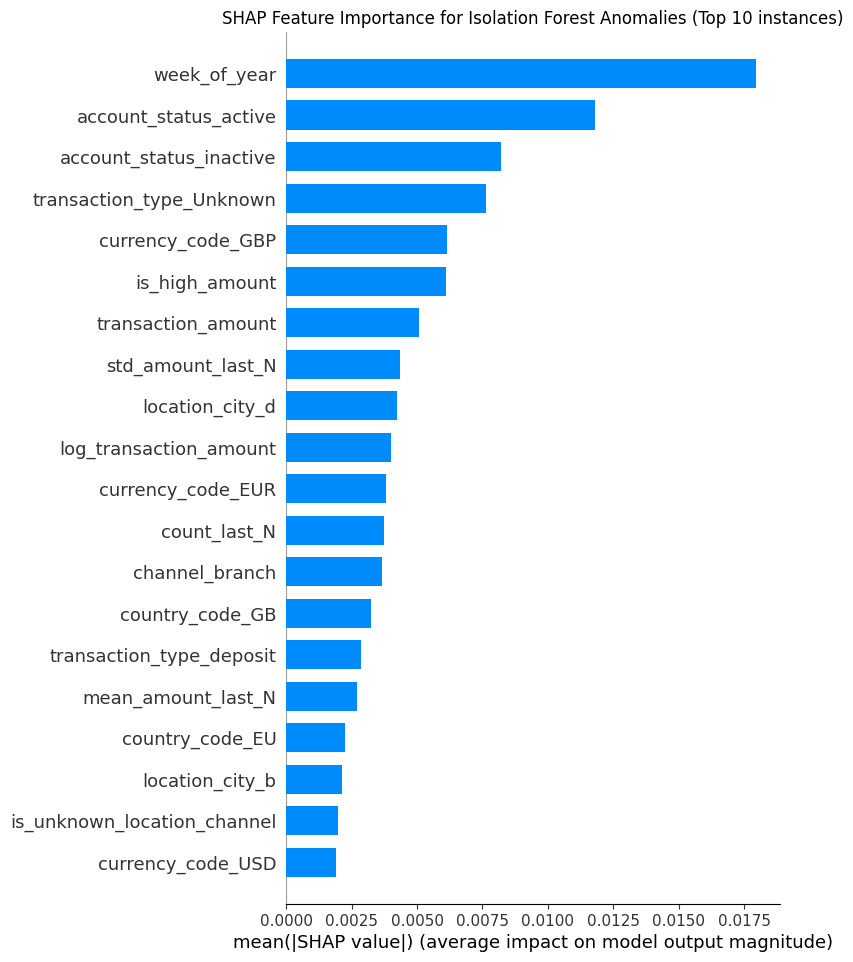

In [9]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf # Import tensorflow as shap might interact with it

# Ensure display is available for dataframe output
from IPython.display import display

# Load the engineered and preprocessed data used for modeling
# We need df_encoded (or equivalent processed data) and the original df for context
# Let's reload the engineered data and re-apply preprocessing for consistency
df = pd.read_csv('synthetic_banking_transactions_engineered.csv')

# Separate features (X) and the true anomaly label (y)
X = df.drop(['transaction_id', 'customer_id', 'account_no', 'payee_account_no',
             'transaction_time', 'customer_address', 'is_anomaly'], axis=1)
y_true = df['is_anomaly']

# Identify categorical and numerical features for preprocessing
categorical_features = X.select_dtypes(include='object').columns
numerical_features = X.select_dtypes(include=np.number).columns

# Create a preprocessing pipeline (should be the same as in step 4)
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Apply preprocessing to the full dataset to get feature names later
X_processed_full = preprocessor.fit_transform(X)

# Convert sparse matrix to dense numpy array if necessary
if hasattr(X_processed_full, 'toarray'):
    X_processed_full = X_processed_full.toarray()

# Get the feature names after preprocessing
# This requires getting the feature names from the OneHotEncoder and combining with numerical feature names
# A common way is to access the fitted transformer within the ColumnTransformer
feature_names = numerical_features.tolist() + \
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
# Ensure the number of feature names matches the processed data shape
if len(feature_names) != X_processed_full.shape[1]:
     print("Warning: Mismatch between generated feature names and processed data shape.")
     # Fallback to generic names if mismatch
     feature_names = [f'feature_{i}' for i in range(X_processed_full.shape[1])]
else:
    print(f"Generated {len(feature_names)} feature names.")


# --- SHAP for LSTM Autoencoder ---
print("\nExplaining Autoencoder Anomalies using SHAP...")

# We need the trained autoencoder model from step 4 and the processed data X_processed_full
# Assuming 'autoencoder' model and 'anomalies_autoencoder' boolean array are available from the previous cell execution.
# If not, the model and anomalies need to be re-computed or loaded.

# Check if autoencoder and anomalies_autoencoder are available
if 'autoencoder' not in locals() or 'anomalies_autoencoder' not in locals():
     print("Autoencoder model or anomaly flags not found. Please run step 4 first.")
else:
    # Select the anomalous instances from the processed data
    X_anomalies_processed = X_processed_full[anomalies_autoencoder]
    # Reshape for LSTM input (samples, timesteps, features) - timesteps=1
    X_anomalies_lstm = np.reshape(X_anomalies_processed, (X_anomalies_processed.shape[0], 1, X_anomalies_processed.shape[1]))

    # Define the prediction function for SHAP (explaining reconstruction error)
    # This function should take a 2D numpy array (samples, features) and output a 1D array (samples,)
    # representing the value we want to explain (e.g., reconstruction error).
    def autoencoder_error_predict(x):
        # Reshape the 2D input to 3D (samples, 1, features) for the autoencoder
        x_reshaped = np.reshape(x, (x.shape[0], 1, x.shape[1]))
        # Get the autoencoder's reconstruction
        reconstruction = autoencoder.predict(x_reshaped, verbose=0) # Use verbose=0 to suppress progress bar
        # Calculate the mean squared error between input and reconstruction for each sample
        # Output shape should be (samples,)
        return np.mean(np.power(x_reshaped - reconstruction, 2), axis=(1,2)) # Mean over timesteps and features

    # Choose a background dataset for the explainer
    # KernelExplainer can be slow, a small background dataset is common.
    # Sample from the non-anomalous data (based on autoencoder detection)
    X_normal_processed = X_processed_full[~anomalies_autoencoder]
    # Ensure there are normal points to sample from
    if X_normal_processed.shape[0] > 100:
        background_indices = np.random.choice(X_normal_processed.shape[0], 100, replace=False)
        background_data = X_normal_processed[background_indices]
        print("Initializing SHAP KernelExplainer for Autoencoder...")

        # Initialize the KernelExplainer
        # KernelExplainer explains the `autoencoder_error_predict` function's output using `background_data`
        explainer_autoencoder = shap.KernelExplainer(autoencoder_error_predict, background_data)

        # Calculate SHAP values for the anomalous instances detected by the autoencoder
        print(f"Calculating SHAP values for {X_anomalies_processed.shape[0]} autoencoder anomalies...")
        # Limit the number of anomalies for explanation due to KernelExplainer speed
        max_anomalies_to_explain = min(X_anomalies_processed.shape[0], 10) # Explain at most 10 anomalies

        if max_anomalies_to_explain > 0:
            X_anomalies_subset = X_anomalies_processed[:max_anomalies_to_explain]
            # Use the original data (before reshaping for LSTM) for SHAP explanation data
            shap_values_autoencoder = explainer_autoencoder.shap_values(X_anomalies_subset)

            # SHAP summary plot for Autoencoder anomalies
            print("\nGenerating SHAP summary plot for Autoencoder anomalies...")
            # shap_values_autoencoder shape should be (num_anomalies_subset, num_features)
            # X_anomalies_subset shape is (num_anomalies_subset, num_features)

            # Ensure feature_names are correctly passed
            if len(feature_names) == shap_values_autoencoder.shape[1]:
                 shap.summary_plot(
                    shap_values_autoencoder, # SHAP values array
                    X_anomalies_subset, # Data points (2D)
                    feature_names=feature_names, # Feature names
                    plot_type='bar', # Bar plot for overall importance
                    show=False
                 )
                 plt.title(f'SHAP Feature Importance for Autoencoder Anomalies (Top {max_anomalies_to_explain} instances)')
                 plt.show()

                 # Optional: Individual force plot for a single anomaly
                 # Choose an index to plot (e.g., the first anomaly in the subset)
                 # print("\nGenerating SHAP force plot for a sample Autoencoder anomaly...")
                 # shap.force_plot(
                 #     explainer_autoencoder.expected_value,
                 #     shap_values_autoencoder[0,:], # SHAP values for the first anomaly
                 #     X_anomalies_subset[0,:], # Feature values for the first anomaly
                 #     feature_names=feature_names,
                 #     matplotlib=True, # Use matplotlib for rendering in notebooks
                 #     show=False
                 # )
                 # plt.title('SHAP Force Plot for a Sample Autoencoder Anomaly')
                 # plt.show()

            else:
                 print("Error: Feature names count mismatch with SHAP values dimensions for Autoencoder.")
                 print(f"Feature names count: {len(feature_names)}, SHAP values dim 1: {shap_values_autoencoder.shape[1]}")

        else:
            print("No autoencoder anomalies to explain.")
            shap_values_autoencoder = None # Set to None if no anomalies explained

    else:
        print("Not enough normal points to create a background dataset for Autoencoder SHAP.")
        shap_values_autoencoder = None # Set to None if no background data


# --- SHAP for Isolation Forest ---
print("\nExplaining Isolation Forest Anomalies using SHAP...")

# We need the trained isolation_forest model from step 4 and the processed data X_processed_full
# Assuming 'isolation_forest' model and 'anomalies_if' boolean array are available.

# Check if isolation_forest and anomalies_if are available
if 'isolation_forest' not in locals() or 'anomalies_if' not in locals():
     print("Isolation Forest model or anomaly flags not found. Please run step 4 first.")
else:
    # Select the anomalous instances from the processed data detected by Isolation Forest
    X_anomalies_if_processed = X_processed_full[anomalies_if]

    # Define the prediction function for SHAP (explaining the anomaly score)
    # Isolation Forest's decision_function returns the score. SHAP explains positive outputs.
    # We want to explain *low* scores (anomalies), so we might explain -score or 1-score.
    # Let's explain the negative of the decision function score, so higher output means more anomalous.
    def isolation_forest_predict(x):
        # decision_function returns (samples,) array
        return -isolation_forest.decision_function(x) # Explain the negative score

    # Choose a background dataset for the explainer (sample from non-anomalous data by IF)
    X_normal_if_processed = X_processed_full[~anomalies_if]
    # Ensure there are normal points to sample from
    if X_normal_if_processed.shape[0] > 100:
        background_indices_if = np.random.choice(X_normal_if_processed.shape[0], 100, replace=False)
        background_data_if = X_normal_if_processed[background_indices_if]
        print("Initializing SHAP KernelExplainer for Isolation Forest...")

        # Initialize the KernelExplainer for Isolation Forest
        explainer_if = shap.KernelExplainer(isolation_forest_predict, background_data_if)

        # Calculate SHAP values for the anomalous instances detected by Isolation Forest
        print(f"Calculating SHAP values for {X_anomalies_if_processed.shape[0]} Isolation Forest anomalies...")
        # Limit the number of anomalies for explanation
        max_anomalies_to_explain_if = min(X_anomalies_if_processed.shape[0], 10) # Explain at most 10 anomalies

        if max_anomalies_to_explain_if > 0:
            X_anomalies_if_subset = X_anomalies_if_processed[:max_anomalies_to_explain_if]
            shap_values_if = explainer_if.shap_values(X_anomalies_if_subset)

            # SHAP summary plot for Isolation Forest anomalies
            print("\nGenerating SHAP summary plot for Isolation Forest anomalies...")
            # shap_values_if shape should be (num_anomalies_subset, num_features)
            # X_anomalies_if_subset shape is (num_anomalies_subset, num_features)

            # Ensure feature_names are correctly passed
            if len(feature_names) == shap_values_if.shape[1]:
                 shap.summary_plot(
                    shap_values_if,
                    X_anomalies_if_subset,
                    feature_names=feature_names,
                    plot_type='bar',
                    show=False
                 )
                 plt.title(f'SHAP Feature Importance for Isolation Forest Anomalies (Top {max_anomalies_to_explain_if} instances)')
                 plt.show()

                 # Optional: Individual force plot for a single anomaly
                 # print("\nGenerating SHAP force plot for a sample Isolation Forest anomaly...")
                 # shap.force_plot(
                 #     explainer_if.expected_value,
                 #     shap_values_if[0,:], # SHAP values for the first anomaly
                 #     X_anomalies_if_subset[0,:], # Feature values for the first anomaly
                 #     feature_names=feature_names,
                 #     matplotlib=True,
                 #     show=False
                 # )
                 # plt.title('SHAP Force Plot for a Sample Isolation Forest Anomaly')
                 # plt.show()

            else:
                 print("Error: Feature names count mismatch with SHAP values dimensions for Isolation Forest.")
                 print(f"Feature names count: {len(feature_names)}, SHAP values dim 1: {shap_values_if.shape[1]}")

        else:
            print("No Isolation Forest anomalies to explain.")
            shap_values_if = None # Set to None if no anomalies explained

    else:
        print("Not enough normal points to create a background dataset for Isolation Forest SHAP.")
        shap_values_if = None # Set to None if no background data

# Note: SHAP calculation for KernelExplainer can be very slow, especially with many features or anomalies.
# The subsetting of anomalies for explanation is crucial for performance in this notebook.
# For a production scenario, consider using other explainers if available for your model type (e.g., DeepExplainer for Keras).

## 6. Generating Adaptive Rules for Detected Anomalies

This section focuses on translating the insights gained from anomaly detection and SHAP explanations into simple, interpretable rules. These rules can potentially be used for filtering or flagging future transactions. We will derive rules based on the characteristics of the detected anomalies and present them in a tabular format along with the anomalies and their top explanatory features.

In [10]:
import pandas as pd
import numpy as np
import shap # Import shap if needed for accessing values/indices
from IPython.display import display

# Load the original engineered data to access original feature values
df_original = pd.read_csv('synthetic_banking_transactions_engineered.csv')

# Load the preprocessed data used for modeling (for feature names and indices)
df_processed = pd.read_csv('synthetic_banking_transactions_preprocessed.csv') # Using preprocessed to get feature names

# Separate features (X) and the true anomaly label (y) from the engineered data
X_engineered = df_original.drop(['transaction_id', 'customer_id', 'account_no', 'payee_account_no',
                                 'transaction_time', 'customer_address', 'is_anomaly'], axis=1)
y_true = df_original['is_anomaly']

# Identify categorical and numerical features (same as in step 4 and 5)
categorical_features = X_engineered.select_dtypes(include='object').columns
numerical_features = X_engineered.select_dtypes(include=np.number).columns

# Re-apply preprocessing to get the processed data and the preprocessor object
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

X_processed_full = preprocessor.fit_transform(X_engineered)

if hasattr(X_processed_full, 'toarray'):
    X_processed_full = X_processed_full.toarray()

# Get the feature names after preprocessing (same as in step 5)
feature_names = numerical_features.tolist() + \
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))


# --- Derive Rules from Detected Anomalies and SHAP Values ---
print("Generating Adaptive Rules...")

# We will use the anomalies detected by the Isolation Forest model for rule generation,
# as Isolation Forest often provides simpler anomaly scores.
# We will use the SHAP values calculated for the Isolation Forest anomalies to identify key features.

# Assuming 'anomalies_if' and 'shap_values_if' variables are available from step 5.
# If not, the Isolation Forest model and SHAP values need to be re-computed or loaded.

if 'anomalies_if' not in locals() or 'shap_values_if' not in locals() or shap_values_if is None or shap_values_if.shape[0] == 0:
     print("Isolation Forest anomalies or SHAP values not found or are empty. Please run step 4 and 5 first.")
     rules_generated = {} # Initialize empty rules
else:
    # Select the anomalous instances from the original engineered dataframe
    # Use the boolean anomaly mask from Isolation Forest
    anomaly_records_engineered = df_original[anomalies_if].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Get the indices of the top features based on mean absolute SHAP values (from Isolation Forest SHAP)
    # We need the mean absolute SHAP values across the *explained* anomalies from step 5.
    # Assuming shap_values_if shape is (num_explained_anomalies, num_features)
    mean_abs_shap_if = np.abs(shap_values_if).mean(axis=0)

    # Get the top N features based on mean absolute SHAP values
    num_top_features = min(10, len(mean_abs_shap_if)) # Select top 10 features or fewer if less available
    top_feature_indices_if = np.argsort(mean_abs_shap_if)[-num_top_features:]

    # Get the actual feature names corresponding to these indices
    # Use the feature_names list generated from the preprocessor
    top_features_if = [feature_names[i] for i in top_feature_indices_if]
    print(f"Top {num_top_features} anomaly-driving features based on Isolation Forest SHAP:", top_features_if)

    # Derive simple rules based on the distribution of these top features in the anomalous records.
    # We will look at the value ranges (min/max or percentiles) of these features
    # specifically within the set of records flagged as anomalous by Isolation Forest.

    rules_generated = {}
    print("\nDerived Rules (based on distribution in Isolation Forest anomalies):")

    # Map processed feature names back to original engineered column names where possible
    # This is tricky with one-hot encoding. For simplicity, we'll derive rules on the
    # *original* values for numerical features and report the dominant category for categorical.
    # This makes rules more interpretable, but might not directly reflect the SHAP values on encoded data.

    # Let's refine: For numerical features, use percentiles from the *original* anomaly records.
    # For one-hot encoded categorical features, identify which category contributed most to SHAP
    # for the top features and report the most frequent original category in anomalies for that feature.

    # Identify which of the top features are numerical vs. one-hot encoded
    top_numerical_features = [f for f in top_features_if if f in numerical_features]
    top_categorical_features_encoded = [f for f in top_features_if if f not in numerical_features] # These are likely one-hot encoded

    # --- Rules for Numerical Features ---
    for feat in top_numerical_features:
        if feat in anomaly_records_engineered.columns:
            values = anomaly_records_engineered[feat]
            # Calculate 5th and 95th percentiles as bounds for the rule
            if not values.empty and not values.isnull().all():
                 rules_generated[feat] = {
                    "type": "numerical_range",
                    "min": values.quantile(0.05),
                    "max": values.quantile(0.95)
                }
                 print(f"Rule: If {feat} is outside range ({rules_generated[feat]['min']:.4f}, {rules_generated[feat]['max']:.4f}) → Possible anomaly")
            else:
                 print(f"Warning: Numerical feature '{feat}' in anomaly records is empty or contains only NaNs. Skipping rule generation for this feature.")
        else:
            print(f"Warning: Numerical feature '{feat}' not found in the engineered anomaly records dataframe.")


    # --- Rules for Categorical Features (from One-Hot Encoding) ---
    # This is more complex. We need to map the encoded feature name back to the original categorical column
    # and find the most frequent value of the original categorical column within the anomalies.
    ohe_feature_map = {}
    # Iterate through the one-hot encoder's categories to build a mapping
    # Assuming the 'cat' transformer is an OneHotEncoder
    if 'cat' in preprocessor.named_transformers_ and isinstance(preprocessor.named_transformers_['cat'], OneHotEncoder):
        ohe = preprocessor.named_transformers_['cat']
        original_cat_cols = ohe.feature_names_in_ # Original categorical column names
        encoded_feature_names_out = ohe.get_feature_names_out(original_cat_cols)

        for i, original_col in enumerate(original_cat_cols):
            # Find the encoded features belonging to this original column
            encoded_features_for_col = [f for f in encoded_feature_names_out if f.startswith(original_col + '_')]
            for encoded_feat in encoded_features_for_col:
                ohe_feature_map[encoded_feat] = original_col

    for encoded_feat in top_categorical_features_encoded:
         if encoded_feat in ohe_feature_map:
            original_cat_col = ohe_feature_map[encoded_feat]
            if original_cat_col in anomaly_records_engineered.columns:
                # Find the most frequent value of the original categorical column in the anomalous records
                most_frequent_value = anomaly_records_engineered[original_cat_col].mode()
                if not most_frequent_value.empty:
                    rules_generated[encoded_feat] = { # Use encoded feature name as key for consistency with top_features_if
                        "type": "categorical_mode",
                        "original_column": original_cat_col,
                        "most_frequent_value_in_anomalies": most_frequent_value.tolist() # mode can return multiple
                    }
                    print(f"Rule: If {original_cat_col} is one of {rules_generated[encoded_feat]['most_frequent_value_in_anomalies']} → Possible anomaly (based on SHAP of {encoded_feat})")
                else:
                    print(f"Warning: Could not find mode for original categorical feature '{original_cat_col}' in anomaly records.")
            else:
                 print(f"Warning: Original categorical column '{original_cat_col}' not found in the engineered anomaly records dataframe.")
         else:
            print(f"Warning: Could not map encoded feature '{encoded_feat}' back to original categorical column.")


# --- Display Anomalies, Reasons (Top SHAP Features), and Rules in Tabular Form ---
print("\nTabular Summary of Anomalies, Reasons, and Rules:")

# Select a subset of anomalous records to display in the table
num_anomalies_to_display = min(20, anomaly_records_engineered.shape[0])
anomalies_for_table = anomaly_records_engineered.head(num_anomalies_to_display).copy()

# Add columns for the top SHAP features and their values in these anomalies
# Add columns for the generated rules
if rules_generated:
    # Create a column to summarize the rules
    rules_summary_list = []
    for feat, rule_info in rules_generated.items():
        if rule_info['type'] == 'numerical_range':
            rules_summary_list.append(f"{feat} outside ({rule_info['min']:.2f}, {rule_info['max']:.2f})")
        elif rule_info['type'] == 'categorical_mode':
             rules_summary_list.append(f"{rule_info['original_column']} in {rule_info['most_frequent_value_in_anomalies']}")

    rules_summary_str = "; ".join(rules_summary_list)
    # Add the summary as a new column to the table dataframe
    anomalies_for_table['Generated_Rules_Summary'] = rules_summary_str

    # Add columns for the values of the top features in these anomalies
    for feat in top_features_if:
        # Need to map encoded feature names back to original columns for display
        original_col_name = ohe_feature_map.get(feat, feat) # Use original name if mapped, otherwise encoded

        if original_col_name in anomalies_for_table.columns:
            anomalies_for_table[f'Value_of_{original_col_name}'] = anomalies_for_table[original_col_name]
        # Note: Displaying SHAP values for each anomaly in the table is complex.
        # We'll focus on the values of the top features in the anomaly records.

    # Select relevant columns for the table: transaction_id, is_anomaly, Value_of_Top_Features, Generated_Rules_Summary
    display_cols = ['transaction_id', 'is_anomaly'] + [f'Value_of_{ohe_feature_map.get(f, f)}' for f in top_features_if if ohe_feature_map.get(f, f) in anomalies_for_table.columns] + ['Generated_Rules_Summary']
    display_cols = list(dict.fromkeys(display_cols)) # Remove duplicates while preserving order

    # Display the resulting table
    display(anomalies_for_table[display_cols])

else:
    print("No rules were generated to display in the table.")

# --- Rule-Based Filtering Function (for future use) ---
# This function applies the generated rules to new data.
def apply_generated_rules(new_data_df, rules, preprocessor_fitted, feature_names_list):
    """
    Applies the generated rules to new data to flag potential anomalies.

    Args:
        new_data_df (pd.DataFrame): DataFrame of new data (should have same columns as original).
        rules (dict): Dictionary containing the generated rules.
        preprocessor_fitted: The fitted ColumnTransformer used for preprocessing.
        feature_names_list (list): List of feature names after preprocessing.

    Returns:
        pd.Series: Boolean Series indicating potential anomalies (True) or not (False).
    """
    if not rules:
        print("No rules provided to apply.")
        return pd.Series([False] * len(new_data_df))

    # Ensure new data has same columns as original, or handle missing columns
    # For simplicity, assume new_data_df has the necessary original columns.

    # Map original column names back to processed feature names for rule application
    # This is needed to check values against the bounds/modes derived on processed features
    # (even though the rules are printed in terms of original values).

    anomaly_flags = pd.Series([False] * len(new_data_df)) # Initialize all as non-anomalous

    # Iterate through each rule
    for rule_feat, rule_info in rules.items():
        # Find the original column name if it's a one-hot encoded feature
        original_col_name = rule_info.get("original_column", rule_feat) # Use original_column if exists, else rule_feat

        if original_col_name not in new_data_df.columns:
            print(f"Warning: Original column '{original_col_name}' needed for rule '{rule_feat}' not found in new data. Skipping this rule.")
            continue

        if rule_info["type"] == "numerical_range":
            min_val = rule_info["min"]
            max_val = rule_info["max"]
            # Check if the original numerical value is outside the defined range
            # Ensure the column is numeric before comparison
            if pd.api.types.is_numeric_dtype(new_data_df[original_col_name]):
                 # Update flags where the rule is violated
                violation_mask = (new_data_df[original_col_name] < min_val) | (new_data_df[original_col_name] > max_val)
                anomaly_flags = anomaly_flags | violation_mask # Flag as anomaly if this rule or any previous rule is violated
            else:
                 print(f"Warning: Numerical rule applied to non-numeric column '{original_col_name}'. Skipping this rule.")

        elif rule_info["type"] == "categorical_mode":
            most_frequent_values = rule_info["most_frequent_value_in_anomalies"]
            # Check if the original categorical value is one of the most frequent values in anomalies
            # Ensure the column is of object/string type
            if pd.api.types.is_object_dtype(new_data_df[original_col_name]):
                 violation_mask = new_data_df[original_col_name].isin(most_frequent_values)
                 anomaly_flags = anomaly_flags | violation_mask
            else:
                 print(f"Warning: Categorical rule applied to non-object column '{original_col_name}'. Skipping this rule.")


    return anomaly_flags

# --- Test the Rule-Based Filtering on the Original Data ---
print("\nTesting rule-based filtering on the original engineered data...")
if rules_generated:
    # Use the original engineered dataframe (before preprocessing for modeling)
    # The function expects a dataframe with original columns.
    rule_detected_anomalies = apply_generated_rules(df_original, rules_generated, preprocessor, feature_names)

    print(f"\nRule engine flagged {sum(rule_detected_anomalies)} potential anomalies.")

    # Optional: Compare rule-based detection with model-based detection (e.g., Isolation Forest)
    if 'anomalies_if' in locals():
        print(f"Isolation Forest detected {sum(anomalies_if)} anomalies.")
        # How many records flagged by rules were also flagged by Isolation Forest?
        true_positives_rules_if = np.sum(np.logical_and(rule_detected_anomalies, anomalies_if))
        print(f"Rules matching Isolation Forest anomalies: {true_positives_rules_if}")

        # How many records flagged by rules were *not* flagged by Isolation Forest? (False Positives of Rules)
        false_positives_rules_if = np.sum(np.logical_and(rule_detected_anomalies, ~anomalies_if))
        print(f"Rules *not* matching Isolation Forest anomalies (Rules False Positives): {false_positives_rules_if}")

        # How many records flagged by Isolation Forest were *not* flagged by rules? (False Negatives of Rules)
        false_negatives_rules_if = np.sum(np.logical_and(~rule_detected_anomalies, anomalies_if))
        print(f"Isolation Forest anomalies *not* caught by rules (Rules False Negatives): {false_negatives_rules_if}")

else:
    print("Skipping rule-based filtering test as no rules were generated.")

Generating Adaptive Rules...
Top 10 anomaly-driving features based on Isolation Forest SHAP: ['log_transaction_amount', 'location_city_d', 'std_amount_last_N', 'transaction_amount', 'is_high_amount', 'currency_code_GBP', 'transaction_type_Unknown', 'account_status_inactive', 'account_status_active', 'week_of_year']

Derived Rules (based on distribution in Isolation Forest anomalies):
Rule: If log_transaction_amount is outside range (0.0000, 11.1942) → Possible anomaly
Rule: If std_amount_last_N is outside range (0.0000, 41448.2094) → Possible anomaly
Rule: If transaction_amount is outside range (0.0000, 72705.6532) → Possible anomaly
Rule: If is_high_amount is outside range (0.0000, 1.0000) → Possible anomaly
Rule: If week_of_year is outside range (1.0000, 52.0000) → Possible anomaly
Rule: If location is one of ['city_a'] → Possible anomaly (based on SHAP of location_city_d)
Rule: If currency_code is one of ['USD'] → Possible anomaly (based on SHAP of currency_code_GBP)
Rule: If transa

,transaction_id,is_anomaly,Value_of_log_transaction_amount,Value_of_location,Value_of_std_amount_last_N,Value_of_transaction_amount,Value_of_is_high_amount,Value_of_currency_code,Value_of_transaction_type,Value_of_account_status,Value_of_week_of_year,Generated_Rules_Summary
48,583,0,8.311279,city_b,1751.299279,4068.515796,0,USD,transfer,inactive,52,"log_transaction_amount outside (0.00, 11.19); ..."
54,715,0,0.000000,city_a,2050.825135,0.000000,0,USD,transfer,inactive,52,"log_transaction_amount outside (0.00, 11.19); ..."
55,724,0,0.000000,city_d,2235.181331,0.000000,0,EUR,transfer,active,52,"log_transaction_amount outside (0.00, 11.19); ..."
68,994,1,11.200308,city_d,31145.582921,73151.952368,1,USD,payment,active,52,"log_transaction_amount outside (0.00, 11.19); ..."
69,0,0,8.492320,city_a,31043.802852,4876.166489,0,GBP,payment,Unknown,52,"log_transaction_amount outside (0.00, 11.19); ..."
83,1234,0,7.779883,city_a,1978.672580,2390.996083,0,GBP,Unknown,active,52,"log_transaction_amount outside (0.00, 11.19); ..."
89,1337,0,6.794546,city_b,2415.186026,891.963744,0,USD,deposit,inactive,52,"log_transaction_amount outside (0.00, 11.19); ..."
93,1410,0,8.214083,city_a,1497.428164,3691.589170,0,GBP,deposit,inactive,52,"log_transaction_amount outside (0.00, 11.19); ..."
95,1437,1,10.185764,city_c,10558.864149,26521.895876,1,EUR,payment,active,52,"log_transaction_amount outside (0.00, 11.19); ..."
96,1463,0,7.348946,Unknown,10835.543458,1553.556585,0,EUR,Unknown,active,1,"log_transaction_amount outside (0.00, 11.19); ..."



Testing rule-based filtering on the original engineered data...

Rule engine flagged 9832 potential anomalies.
Isolation Forest detected 501 anomalies.
Rules matching Isolation Forest anomalies: 420
Rules *not* matching Isolation Forest anomalies (Rules False Positives): 9412
Isolation Forest anomalies *not* caught by rules (Rules False Negatives): 81
